In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from cvxopt import matrix, solvers
 

In [4]:
#ucitavanje dataseta
df=pd.read_csv('svmData.csv', header=None)

In [5]:
#razdvajanje prediktora i labels
X_df=df.iloc[:,:2]
Y_df=df.iloc[:,2:]

#standardizacija
srv=X_df.mean()
std=X_df.std(ddof=0)
X_df=(X_df - srv)/std
X_df=np.array(X_df)
Y_df=np.array(Y_df)

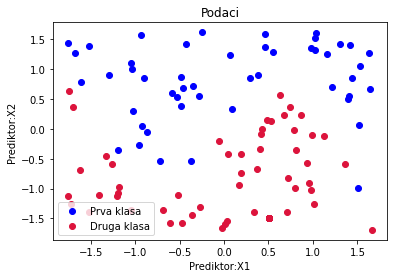

In [6]:
#prikaz linerno neseparabilnih podataka
plt.figure()
plt.title("Podaci")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_df[np.where(Y_df==1),0],X_df[np.where(Y_df==1),1], color="blue",label='Prva klasa')
plt.scatter(X_df[np.where(Y_df==-1),0],X_df[np.where(Y_df==-1),1],color="crimson", label='Druga klasa')
plt.legend(loc="best")
plt.show()

In [9]:
X=np.mat(X_df)

srvr = np.zeros(X.shape[1])
stdev = np.zeros(X.shape[1])
for i in range(X.shape[1]):
    srvr[i] = np.mean(X[:, i])
    stdev[i] = np.std(X[:, i])

for i in range(X.shape[1]):
    for j in range(X.shape[0]):
        X[j,i] = ((X[j,i]) - srvr[i]) / stdev[i]
       

In [38]:
def Gaus_kernel(x,z,sigma=0.5):
  K=np.exp(-np.linalg.norm(x-z)**2 / (2 * (sigma ** 2)))
  return K

In [39]:
#podela dataseta na trenig i test
X_train,X_test,Y_train,Y_test=train_test_split(X_df,Y_df)

In [40]:

c= [0.1, 1,10, 100]
loss_c=np.zeros(len(c))
valid_split=5
error_valid=np.zeros(valid_split)
indices = np.arange(len(X_train))
folds = np.array_split(indices, indices_or_sections=valid_split)
for c_ind,c_i in enumerate(c):
  #cross validacija da bismo nasli optimalo sarka penal C,C je parametar regularizacije
  for k, fold in enumerate(folds):
        X_valid, y_valid = np.mat(X_train[folds[k]]), np.mat(Y_train[folds[k]])
        train_indices = np.concatenate([folds[p] for p in range(len(folds)) if p != k])
        train_X, train_y = np.mat(X_train[train_indices]), np.mat(Y_train[train_indices])
        m,n=train_X.shape
        m_v,n_v=X_valid.shape
        #definisemo parametre za kvadratno programiranje
        H=np.zeros((m,m))
        for i in range(m):
          for j in range(m):
            H[i,j]=Gaus_kernel(train_X[i],train_X[j])
        P = matrix(np.outer(train_y,train_y)*H)
        q = matrix(np.repeat([-1.0], m)[:, None])
        #q = matrix(-np.ones((m, 1)))
        G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = matrix(np.hstack((np.zeros(m), np.ones(m) * c_i)))  
        A = matrix(train_y.reshape(1, -1))
        A = A * 1.0 #mora A da bude tipa float
        b = matrix(np.zeros(1))
        solvers.options['show_progress'] = False
        solver = solvers.qp(P, q, G, h, A, b)
        alfa = np.ravel(solver['x'])
        for j in range (m_v):
            sumay=0
            sumab=0
            #trazimo alfa koje je rezlicito od 0, tj trazimo nosece vektore
            sv= np.where((alfa>1e-5)&(alfa<=c_i))
            ind = np.arange(len(alfa))[sv] #dobijamo indekse na kojima se nalaze noseci vektori
            
            
            for i in range(m):
                #print("alfa k je", alfa[i])
                sumay= sumay + alfa[i]*Y_train[i]* Gaus_kernel(np.matrix(X_valid[j,:]),np.matrix(train_X[i,:]))
                sumab= sumab + alfa[k]* Y_train[i]* Gaus_kernel(np.matrix(train_X[ind,:]),np.matrix(train_X[i,:]))

            b= np.mean(Y_train[ind]- sumab)  # računanje parametra b  
            ypred= np.sign(sumay + b)
            if(ypred * y_valid[j]>0):
              error_valid[k] = error_valid[k] + 1
            error_valid[k] = error_valid[k]/m_v
  loss_c[c_ind]= np.sum(error_valid)/valid_split
  print(loss_c)
           
        

[0.04292088 0.         0.         0.        ]
[0.04292088 0.0429801  0.         0.        ]
[0.04292088 0.0429801  0.04297984 0.        ]
[0.04292088 0.0429801  0.04297984 0.04297984]


In [41]:
c_optimal=c[np.argmin(loss_c)]
print(c_optimal)

0.1


In [42]:
m,n=X_train.shape

#definisemo parametre za kvadratno programiranje
H=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        H[i,j]=Gaus_kernel(X_train[i],X_train[j])
P = matrix(np.outer(Y_train,Y_train)*H)
q = matrix(np.repeat([-1.0], m)[:, None])
#q = matrix(-np.ones((m, 1)))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * c_i)))  
A = matrix(Y_train.reshape(1, -1))
A = A * 1.0 #mora A da bude tipa float
b = matrix(np.zeros(1))
solvers.options['show_progress'] = False
solver = solvers.qp(P, q, G, h, A, b)
alfa = np.ravel(solver['x'])

In [43]:
xmin = -2
xmax= 2
ymin= -2
ymax= 2
N= 100

xx= np.linspace(xmin,xmax,num=N,endpoint=True)
yy= np.linspace(ymin,ymax,num=N,endpoint=True)
ypred= np.zeros((N,N))

for i in range(0,N):
    
    for j in range(0,N):
        sumay=0
        sumab=0
        #trazimo alfa koje je rezlicito od 0, tj trazimo nosece vektore
        sv= np.where((alfa>1e-5)&(alfa<=c_i))
        ind = np.arange(len(alfa))[sv] #dobijamo indekse na kojima se nalaze noseci vektori
        
        for k in range(0,X_train.shape[0]):
            sumay= sumay + alfa[k]* Y_train[k]* Gaus_kernel(np.matrix([xx[i],yy[j]]),np.matrix(X_train[k,:]))
            sumab= sumab + alfa[k]* Y_train[k]* Gaus_kernel(np.matrix(X_train[ind,:]),np.matrix(X_train[k,:]))
            
        b= np.mean(Y_train[ind]- sumab)
        ypred[i,j]= sumay + b
        
ypred_fin= np.sign(ypred)



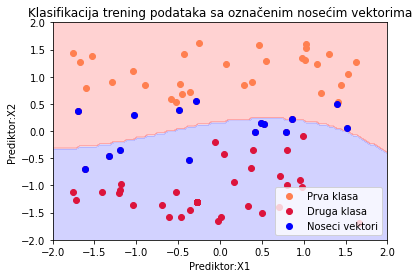

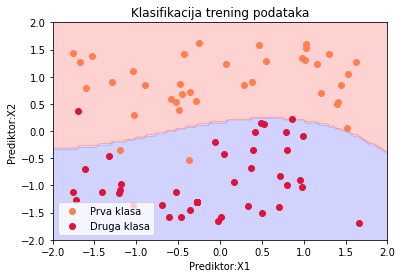

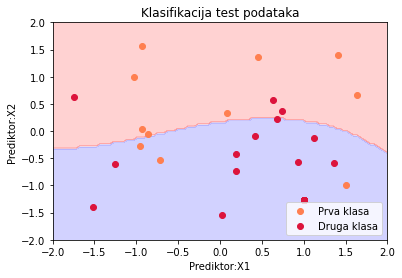

In [37]:
xx1, yy1 = np.meshgrid(np.linspace(xmin,xmax,num=N,endpoint=True),np.linspace(ymin,ymax,num=N,endpoint=True))
plt.contourf(xx1,yy1,ypred_fin.transpose(),alpha=0.2,cmap='bwr')

plt.title("Klasifikacija trening podataka sa označenim nosećim vektorima")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_train[np.where(Y_train==1),0],X_train[np.where(Y_train==1),1], color="coral",label='Prva klasa')
plt.scatter(X_train[np.where(Y_train==-1),0],X_train[np.where(Y_train==-1),1],color="crimson", label='Druga klasa')

plt.scatter(X_train[ind,0],X_train[ind,1],color="blue",label='Noseci vektori')
plt.legend(loc="best")
plt.show()

xx1, yy1 = np.meshgrid(np.linspace(xmin,xmax,num=N,endpoint=True),np.linspace(ymin,ymax,num=N,endpoint=True))
plt.contourf(xx1,yy1,ypred_fin.transpose(),alpha=0.2,cmap='bwr')

plt.title("Klasifikacija trening podataka")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_train[np.where(Y_train==1),0],X_train[np.where(Y_train==1),1], color="coral",label='Prva klasa')
plt.scatter(X_train[np.where(Y_train==-1),0],X_train[np.where(Y_train==-1),1],color="crimson", label='Druga klasa')
plt.legend(loc="best")
plt.show()    

xx1, yy1 = np.meshgrid(np.linspace(xmin,xmax,num=N,endpoint=True),np.linspace(ymin,ymax,num=N,endpoint=True))
plt.contourf(xx1,yy1,ypred_fin.transpose(),alpha=0.2,cmap='bwr')

plt.title("Klasifikacija test podataka")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_test[np.where(Y_test==1),0],X_test[np.where(Y_test==1),1], color="coral",label='Prva klasa')
plt.scatter(X_test[np.where(Y_test==-1),0],X_test[np.where(Y_test==-1),1],color="crimson", label='Druga klasa')
plt.legend(loc="best")
plt.show()  